In [1]:
%load_ext autoreload
%autoreload 2

In [115]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# set sns style to sci
sns.set_style("whitegrid")

sys.path.append("../")
from UpStraight_Visualize import plot_day
from UpStraight_Data import get_appData, get_health_data, training_columns, get_training_data

In [91]:
appData = get_appData(save=True)

In [51]:
health = get_health_data(save=True)

/Users/lasse/Library/Mobile Documents/com~apple~CloudDocs/Health Data/watch_data/UpStraight_analytics/notebooks/../UpStraight_Data.py:44: DtypeWarning: Columns (16,24,25,27,39,40,47,56) have mixed types. Specify dtype option on import or set low_memory=False.
  health.to_csv("../data/health.csv",index=False)
/Users/lasse/Library/Mobile Documents/com~apple~CloudDocs/Health Data/watch_data/UpStraight_analytics/notebooks/../apple_watch_data_package/Apple_Data.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["start"] = pd.to_datetime(data.startDate)
/Users/lasse/Library/Mobile Documents/com~apple~CloudDocs/Health Data/watch_data/UpStraight_analytics/notebooks/../apple_watch_data_package/Apple_Data.py:17: SettingWithCopyWarning: 
A value is t

In [37]:
# get min and max date for each source
appData.groupby("source").agg({"day_date":["min","max","count"]})

day_date                  
               min         max count
source                              
as      2023-02-12  2023-03-13    81
cr      2023-02-10  2023-03-01   139
dotz    2023-02-12  2023-02-25    90
far     2023-02-12  2023-02-22    41
lass    2023-02-10  2023-02-23   116

In [38]:
# get min and max daydate from health_as
health.groupby("source").agg({"day_date":["min","max","count"]})

day_date                   
               min         max  count
source                               
as      2023-02-12  2023-03-13   8502
cr      2023-02-10  2023-03-02  31492
dotz    2023-02-12  2023-03-01  78609
far     2023-02-12  2023-02-26  26019
lass    2023-02-10  2023-03-02  83752

### Cross sectional plots

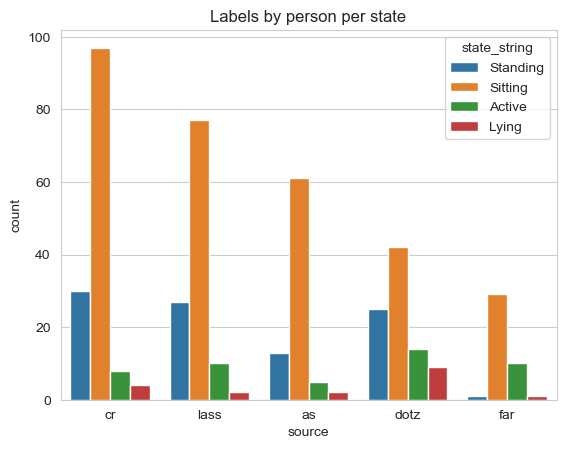

In [21]:
# plotting relative proportions of each state
sns.countplot(appData,x="source",hue="state_string")
plt.title("Labels by person per state")
plt.show()

In [ ]:
# summary table of counts by source and state
appData.groupby(["source","state_string"]).size().unstack().fillna(0).astype(int)

state_string,Active,Lying,Sitting,Standing
source,,,,
as,5,2,61,13
cr,8,4,97,30
dotz,14,9,42,25
far,10,1,29,1
lass,10,2,77,27


### Model

One can either train a model for each user, or a combined model for all at once.
The likely optimal approach is a combination of both: We train a model for each user, using however all of the available data, and adjusting the weights.

**Outline**

- For each user, his own observations will be weighed more heavily than the observations of other users.
- In addition, the loss function will be conservative, i.e. it will penalize more heavily false positives than false negatives. 

**Architecture**

- DecisionTree
- LogisticRegression
- RandomForest

In [108]:
X_train = get_training_data(save=False)
X_train.shape

/Users/lasse/Library/Mobile Documents/com~apple~CloudDocs/Health Data/watch_data/UpStraight_analytics/notebooks/../UpStraight_Data.py:59: DtypeWarning: Columns (10,16,17,18,27,32,33,35,41,54,60,65) have mixed types. Specify dtype option on import or set low_memory=False.
  health = health[health["type"].isin(feature_columns)]
/Users/lasse/Library/Mobile Documents/com~apple~CloudDocs/Health Data/watch_data/UpStraight_analytics/notebooks/../apple_watch_data_package/Apple_Data.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["start"] = pd.to_datetime(data.startDate)
/Users/lasse/Library/Mobile Documents/com~apple~CloudDocs/Health Data/watch_data/UpStraight_analytics/notebooks/../apple_watch_data_package/Apple_Data.py:17: SettingWithCopyWarn

(467, 44)

#### Feature Analysis

In [113]:
X_train.isna().sum()

date                               0
state                              0
posture                            0
source                             0
day_date                           0
day                                0
time                               0
hour                               0
state_string                       0
posture_string                     0
HeartRate_15_mean                 21
HeartRate_15_max                  21
HeartRate_15_min                  21
HeartRate_15_std                  36
HeartRate_15_range                21
ActiveEnergyBurned_15_mean        12
ActiveEnergyBurned_15_max         12
ActiveEnergyBurned_15_min         12
ActiveEnergyBurned_15_std         17
ActiveEnergyBurned_15_range       12
AppleStandTime_15_mean            26
AppleStandTime_15_max             26
AppleStandTime_15_min             26
AppleStandTime_15_range           26
HeartRate_15_ar1_coef              0
ActiveEnergyBurned_15_ar1_coef     0
HeartRate_30_mean                 19
H

In [110]:
# drop apple stand time variation: it has the most missing values and is likely not very informative
X_train.drop(["AppleStandTime_30_std","AppleStandTime_15_std"],axis=1,inplace=True)

In [111]:
# drop rows with missing values
X_prep = X_train.dropna()
X_prep.shape

(415, 42)

I tested some decision trees and they performed quite poorly...

In [194]:
from Upstraight_Train import split_data, get_training_weights
from sklearn.ensemble import RandomForestClassifier

def cv_train_user(X, source, target_weight=0.7):
    X_train, X_test, y_train, y_test = split_data(X_prep,source=source)
    param_grid = {"clf__max_depth": [3,4,5,7,9],"clf__n_estimators": [10,20,30,40,50]}
    rf_grid = GridSearchCV(Pipeline([("col_selector",ColumnSelector(columns=training_columns)),("clf",RandomForestClassifier())]),param_grid=param_grid,cv=4,scoring="accuracy",verbose=1,n_jobs=-1)
    rf_results = rf_grid.fit(X_train,y_train,clf__sample_weight= get_training_weights(X_train,"cr",target=target_weight))
    print(f"Best params: {rf_results.best_params_}")
    return pd.DataFrame(rf_results.cv_results_)

In [209]:


param_grid = {"clf__max_depth": [3,4,5,7,9],"clf__n_estimators": [10,20,30,40,50]}
rf_grid = GridSearchCV(Pipeline([("col_selector",ColumnSelector(columns=training_columns)),("clf",RandomForestClassifier())]),param_grid=param_grid,cv=4,scoring="accuracy",verbose=1,n_jobs=-1)

rf_results = rf_grid.fit(X_train,y_train,clf__sample_weight= get_training_weights(X_train,"cr",0.7))
rf_results.best_params_

Fitting 4 folds for each of 25 candidates, totalling 100 fits


{'clf__max_depth': 9, 'clf__n_estimators': 40}

In [210]:
pd.DataFrame(rf_results.cv_results_).sort_values("mean_test_score",ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
23,0.051021,0.008753,0.003086,0.000994,9,40,"{'clf__max_depth': 9, 'clf__n_estimators': 40}",0.632653,0.744898,0.653061,0.670103,0.675179,0.042380,1
22,0.050509,0.016959,0.002624,0.000446,9,30,"{'clf__max_depth': 9, 'clf__n_estimators': 30}",0.581633,0.755102,0.622449,0.701031,0.665054,0.067412,2
24,0.061155,0.010140,0.003755,0.001638,9,50,"{'clf__max_depth': 9, 'clf__n_estimators': 50}",0.581633,0.744898,0.653061,0.659794,0.659846,0.057873,3
16,0.021738,0.003931,0.003871,0.002689,7,20,"{'clf__max_depth': 7, 'clf__n_estimators': 20}",0.540816,0.714286,0.653061,0.721649,0.657453,0.072413,4
11,0.023286,0.003864,0.003066,0.002266,5,20,"{'clf__max_depth': 5, 'clf__n_estimators': 20}",0.500000,0.765306,0.653061,0.711340,0.657427,0.099180,5


In [206]:
est = rf_results.best_estimator_

from sklearn.metrics import confusion_matrix, classification_report

y_pred = est.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.30      0.43      0.35         7
           0       0.00      0.00      0.00         6
           1       0.43      0.55      0.48        11

    accuracy                           0.38        24
   macro avg       0.24      0.32      0.28        24
weighted avg       0.28      0.38      0.32        24

[[3 0 4]
 [2 0 4]
 [5 0 6]]


/Users/lasse/miniconda3/envs/eda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lasse/miniconda3/envs/eda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lasse/miniconda3/envs/eda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

<AxesSubplot: >

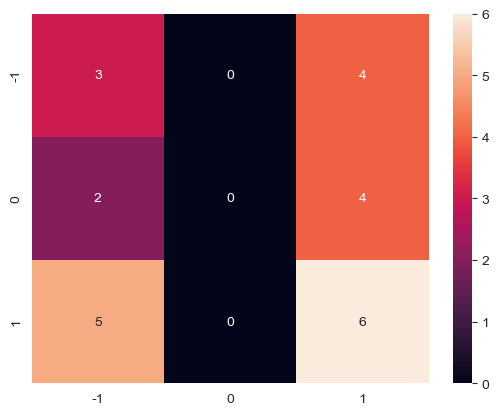

In [208]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt="d",xticklabels=[-1,0,1],yticklabels=[-1,0,1])